# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [92]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.13, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5', 's2', 's7', 's6','s3', 's4']
plotting_order_1percent = ['s11', 's08', 's13', 's12','s09','s10']

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.8857, 'Xe-100':0.895285, 'VOYGR':0.881427}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [3]:
def commodity_to_LWR(transactions_df, commodity, prototype):
    '''
    Finds the transactions of a specific commodity sent to the LWRs in the
    simulation, modifies the time column, and adds in zeros for any time step
    without a transaction to the LWRs, and sums all transactions for
    a single time step

    Parameters:
    -----------
    transactions_df: dataframe
        dataframe of transactions with the prototype name
        of the receiver agent added in. use add_receiver_prototype to get this
        dataframe
    commodity: str
        commodity of interest
    prototype: str
        name of non-LWR reactor prototype in the simulation

    Output:
    -------
    prototype_transactions: dataframe
        contains summed transactions at each time step that are sent to
        the specified prototype name.
    '''
    prototype_transactions = tm.find_commodity_transactions(
        transactions_df, commodity)
    prototype_transactions = prototype_transactions[~prototype_transactions['Prototype'].isin(prototype)]
    prototype_transactions = tm.sum_and_add_missing_time(prototype_transactions)
    prototype_transactions = tm.add_year(prototype_transactions)
    return prototype_transactions

In [4]:
s1_outfile = "../outputs/united_states_2020.sqlite"

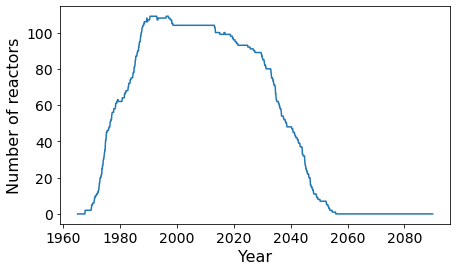

In [5]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

plt.figure(figsize=(7,4))
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'])
plt.xlabel('Year', size=16)
plt.ylabel('Number of reactors', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_reactors.pdf')

In [6]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [7]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1095])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
1091             0.0  2055.92
1092             0.0  2056.00
1093             0.0  2056.08
1094             0.0  2056.17


In [8]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

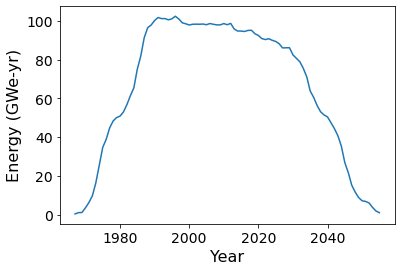

In [109]:
plt.plot(s1_energy['Year'], s1_energy['Energy'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_energy.pdf')

In [10]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

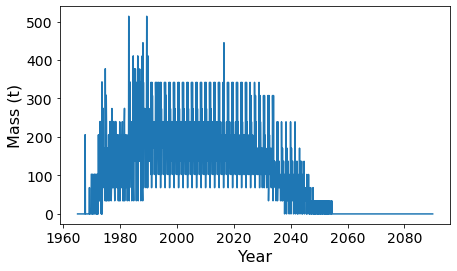

In [11]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.figure(figsize=(7,4))
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (t)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf')

In [12]:
print(s1_uox['Quantity'].max())
print(s1_uox['Quantity'].mean())
print(s1_uox['Quantity'][721:1089].mean())

513717.84232364414
95653.23651452248
81110.40952552758


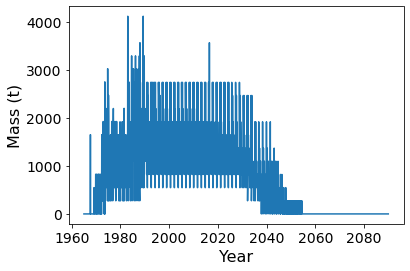

In [13]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [14]:
print(s1_feed.max())
print(s1_feed.mean())
print(s1_feed[721:1089].mean())

4121806.5626750314
767472.1520734677
650788.0216333915


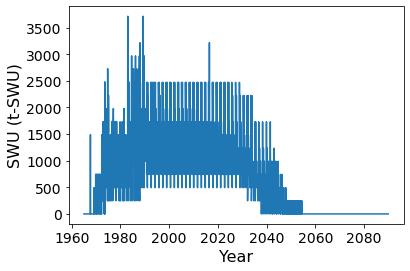

In [15]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (t-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [16]:
print(s1_swu.max())
print(s1_swu.mean())
print(s1_swu[721:1089].mean())

3714166.4210974053
691570.3716354567
586426.1169098741


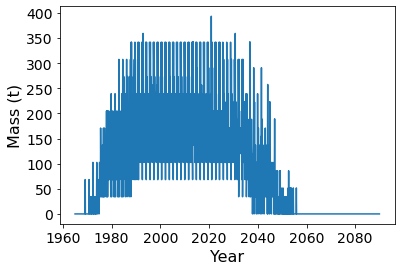

In [17]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf')

In [18]:
print(s1_waste['Quantity'].max())
print(s1_waste['Quantity'].mean())
print(s1_waste['Quantity'][721:1089].mean())

393622.40663899935
91721.28630705364
93898.30642251472


## No growth scenarios

In [19]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

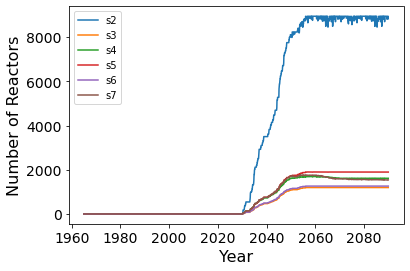

In [110]:
reactors_nogrowth = {'s2_reactors':"",
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'], reactors_nogrowth[key]['advrx_total'], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

In [23]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario};', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 8946.0
Max MMR added in one step in S2: 378.0
Total number of MMR deployed in S2; 25887.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2; 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2; 0.0
Max Adv Rx in S2: 8946.0
Max Adv Rx added in one step in S2: 378.0
Total number of reactors deployed in S2: 25887.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3; 0.0
Max Xe-100 in S3: 1193.0
Max Xe-100 added in one step in S3: 50.0
Total number of Xe-100 deployed in S3; 1193.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3; 0.0
Max Adv Rx in S3: 1193.0
Max Adv Rx added in one step in S3: 50.0
Total number of reactors deployed in S3: 1193.0
Max MMR in S4: 623.0
Max MMR added in one step in S4: 26.0
Total number of MMR deployed in S4; 1587.0
Max Xe-100 in S4: 1128.0
Max Xe-100 added in o

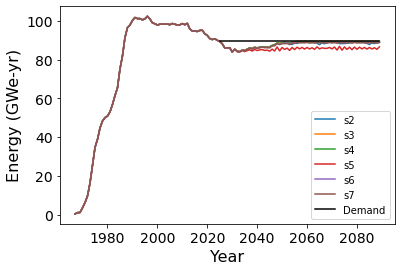

In [111]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf')

In [28]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2_fuel':'', 's3_fuel':'', 's4_fuel':'',
             's5_fuel':'', 's6_fuel':'', 's7_fuel':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = tm.add_year(fuel)

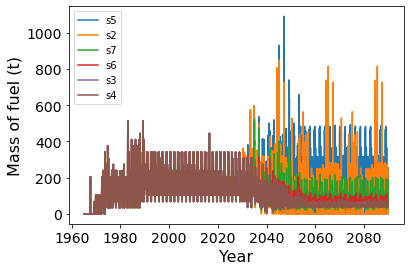

In [112]:
for key in plotting_order_nogrowth: 
    fuel = key+'_fuel'
    plt.plot(total_fuel_nogrowth[fuel]['Year'], total_fuel_nogrowth[fuel]['Quantity']/1000, label=key)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass of fuel (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_fuel.pdf')

In [90]:
#Dividing fuel mass by prototype
fuel_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'',}
for key in fuel_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        fuel_to_reactors_nogrowth[key] = commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    else: 
        fuel_to_reactors_nogrowth[key] = tm.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)

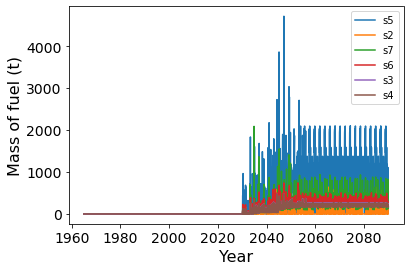

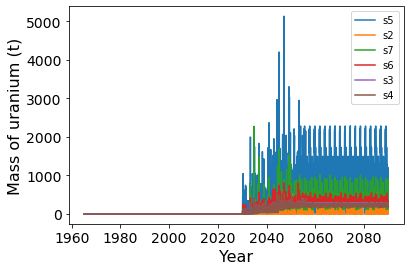

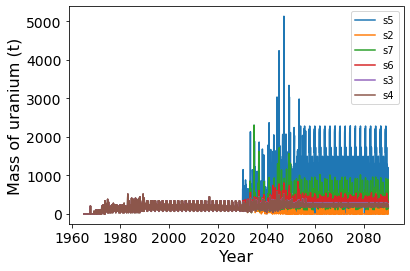

In [113]:
for key in plotting_order_nogrowth:
    
    plt.figure(0)
    AR_fuel = fuel_to_reactors_nogrowth[key + '_MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_fuel['Quantity'] += fuel_to_reactors_nogrowth[key+'_'+reactor]['Quantity']
    plt.plot(AR_fuel['Year'], AR_fuel['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of fuel (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_fuel.pdf')
    
    plt.figure(1)
    AR_uranium = fuel_to_reactors_nogrowth[key + '_MMR']
    AR_uranium['Quantity'] = AR_uranium['Quantity']*uranium_fractions['MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += fuel_to_reactors_nogrowth[key+'_'
                                  +reactor]['Quantity']*uranium_fractions[reactor]
    plt.plot(AR_uranium['Year'], AR_uranium['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_uranium.pdf')
    
    plt.figure(2)
    total_uranium = AR_uranium['Quantity'] + fuel_to_reactors_nogrowth[key+'_LWR']['Quantity']*uranium_fractions['LWR']
    plt.plot(AR_uranium['Year'], total_uranium/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_uranium.pdf')

In [34]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
for key in feed_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    tails_nogrowth[key] = tm.calculate_tails(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor], 
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_nogrowth[key] = tm.calculate_feed(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor], 
                                           tails_nogrowth[key])
    SWU_nogrowth[key] = tm.calculate_SWU(fuel_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

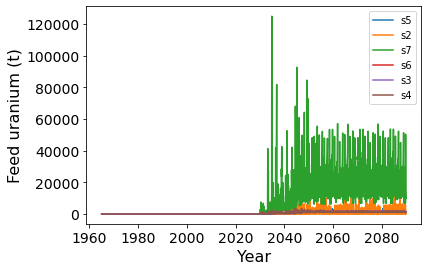

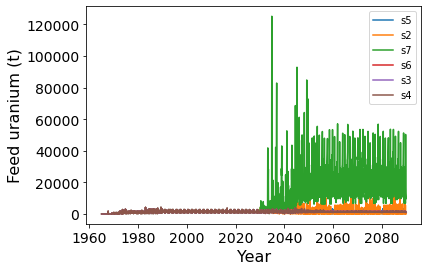

In [121]:
for key in plotting_order_nogrowth:
    AR_feed = feed_nogrowth[key+'_MMR']
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], AR_feed/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_feed.pdf')
    
    plt.figure(1)
    feed_total = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], feed_total/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_feed.pdf')

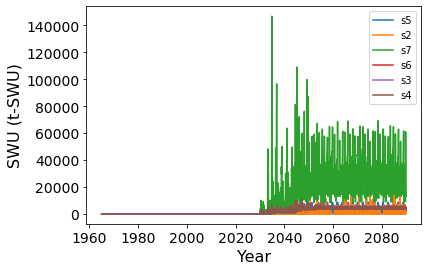

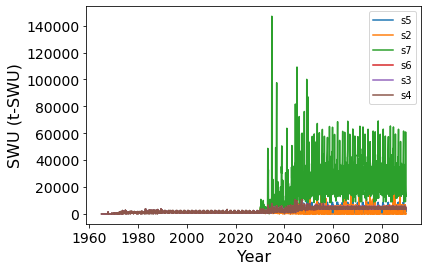

In [114]:
for key in plotting_order_nogrowth:
    AR_SWU = SWU_nogrowth[key+'_MMR']
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], AR_SWU/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_SWU.pdf')
    
    plt.figure(1)
    SWU_total = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(fuel_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_total/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_SWU.pdf')

In [40]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    waste_nogrowth[key] = tm.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

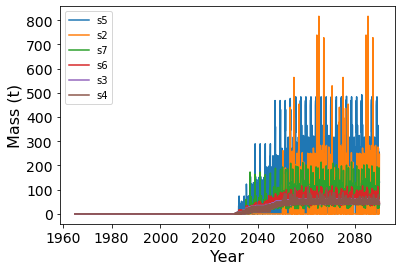

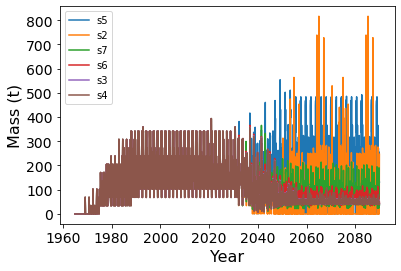

In [41]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'], AR_waste['Quantity']/1000, label = key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_AR_waste.pdf')
    
    plt.figure(1)
    total_waste = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], total_waste/1000, label=key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_waste.pdf')

## 1% Growth Scenarios

In [65]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}

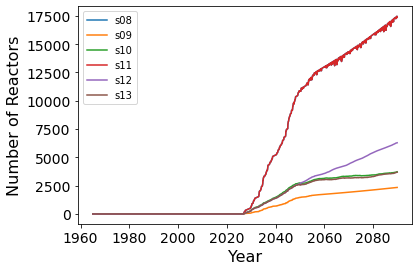

In [115]:
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'], reactors_1percent[key]['advrx_total'], label=scenario)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.png', bbox_inches='tight')

In [68]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario};', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S08: 17467.0
Max MMR added in one step in S08: 412.0
Total number of MMR deployed in S08; 43132.0
Max Xe-100 in S08: 0.0
Max Xe-100 added in one step in S08: 0.0
Total number of Xe-100 deployed in S08; 0.0
Max VOYGR in S08: 0.0
Max VOYGR added in one step in S08: 0.0
Total number of VOYGR deployed in S08; 0.0
Max Adv Rx in S08: 17467.0
Max Adv Rx added in one step in S08: 412.0
Total number of reactors deployed in S08: 43132.0
Max MMR in S09: 0.0
Max MMR added in one step in S09: 0.0
Total number of MMR deployed in S09; 0.0
Max Xe-100 in S09: 2339.0
Max Xe-100 added in one step in S09: 52.0
Total number of Xe-100 deployed in S09; 2339.0
Max VOYGR in S09: 0.0
Max VOYGR added in one step in S09: 0.0
Total number of VOYGR deployed in S09; 0.0
Max Adv Rx in S09: 2339.0
Max Adv Rx added in one step in S09: 52.0
Total number of reactors deployed in S09: 2339.0
Max MMR in S10: 1671.0
Max MMR added in one step in S10: 49.0
Total number of MMR deployed in S10; 4949.0
Max Xe-100 in S1

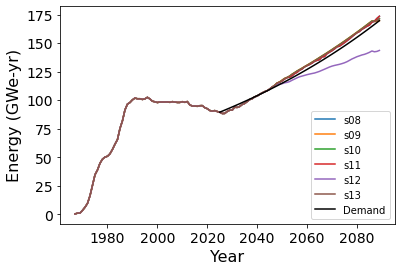

In [116]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}
for key in energy_1percent:
    scenario = key[:3]
    energy_1percent[key] = tm.get_annual_electricity(out_files_1percent[scenario + '_outfile'])
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=scenario)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf')

In [71]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08_fuel':'', 's09_fuel':'', 's10_fuel':'',
             's11_fuel':'', 's12_fuel':'', 's13_fuel':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

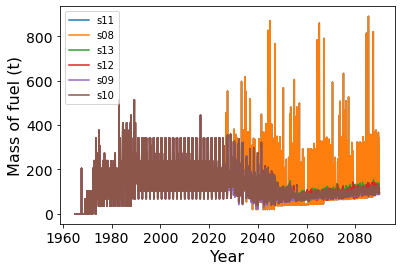

In [117]:
for key in plotting_order_1percent: 
    fuel = key+'_fuel'
    plt.plot(total_fuel_1percent[fuel]['Year'], total_fuel_1percent[fuel]['Quantity']/1000, label=key)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass of fuel (t)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_fuel.pdf')

In [96]:
#Dividing fuel mass by prototype
fuel_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

for key in fuel_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        fuel_to_reactors_1percent[key] = commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    else: 
        fuel_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)

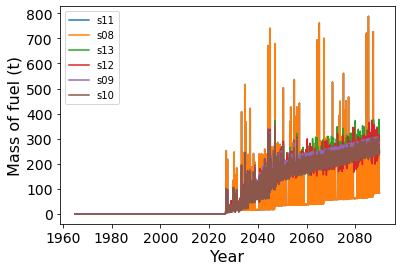

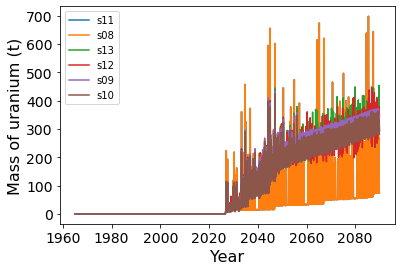

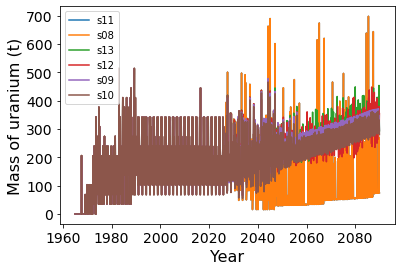

In [118]:
for key in plotting_order_1percent:

    plt.figure(0)
    AR_fuel = fuel_to_reactors_1percent[key + '_MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_fuel['Quantity'] += fuel_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_fuel['Year'], AR_fuel['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of fuel (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_fuel.pdf')

    plt.figure(1)
    AR_uranium = fuel_to_reactors_1percent[key + '_MMR']
    AR_uranium['Quantity'] = AR_uranium['Quantity']*uranium_fractions['MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += fuel_to_reactors_1percent[key+'_'
                                  +reactor]['Quantity']*uranium_fractions[reactor]
    plt.plot(AR_uranium['Year'], AR_uranium['Quantity']/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_uranium.pdf')

    plt.figure(2)
    total_uranium = AR_uranium['Quantity'] + fuel_to_reactors_1percent[key+'_LWR']['Quantity']*uranium_fractions['LWR']
    plt.plot(AR_uranium['Year'], total_uranium/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_uranium.pdf')

In [100]:
#SWU Calculations

tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    tails_1percent[key] = tm.calculate_tails(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor], 
                                    assays[reactor], assays['tails'], assays['feed'])
    feed_1percent[key] = tm.calculate_feed(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor], 
                                           tails_1percent[key])
    SWU_1percent[key] = tm.calculate_SWU(fuel_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

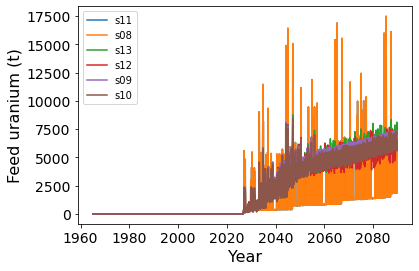

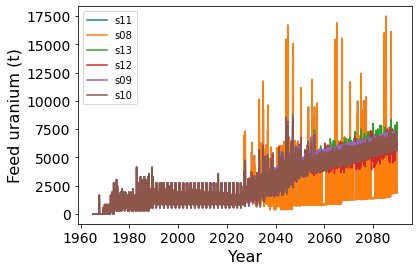

In [122]:
for key in plotting_order_1percent:
    AR_feed = feed_1percent[key+'_MMR']
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], AR_feed/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_feed.pdf')
    
    plt.figure(1)
    feed_total = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], feed_total/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_feed.pdf')

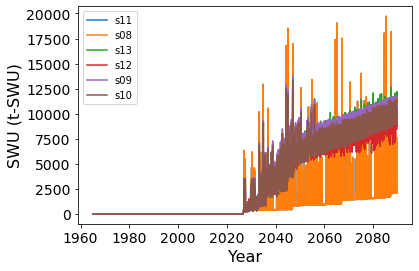

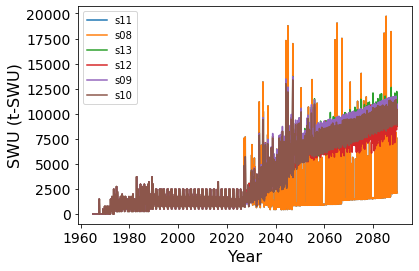

In [119]:
for key in plotting_order_1percent:
    AR_SWU = SWU_1percent[key+'_MMR']
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], AR_SWU/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_SWU.pdf')
    
    plt.figure(1)
    SWU_total = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(fuel_to_reactors_1percent[key + '_MMR']['Year'], SWU_total/1000, label=key)
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (t-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_SWU.pdf')

In [102]:
# Waste discharged from reactors

waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

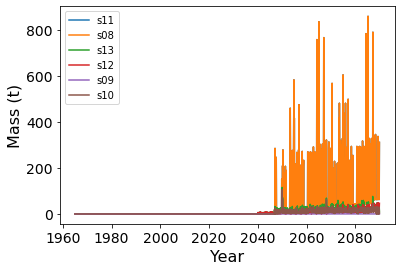

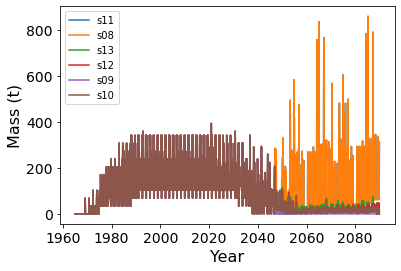

In [83]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'], AR_waste['Quantity']/1000, label = key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_AR_waste.pdf')

    plt.figure(1)
    total_waste = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], total_waste/1000, label=key)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (t)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_waste.pdf')